In [47]:
import argparse, os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, add, Permute, Conv2D
from tensorflow.keras import backend as K
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense, Lambda,
                                         GlobalAveragePooling2D, GlobalMaxPooling2D,
                                         MaxPooling2D, Input, LeakyReLU, concatenate, add)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import is_keras_tensor
from tensorflow.keras.utils import get_source_inputs

model_dir  = "./"
data_dir   ='../vehicle'

os.environ["CUDA_VISIBLE_DEVICES"]="0"

# input data

In [48]:
features = []
labels = []
classes = ['Bus', 'Car', 'motorcycle', 'Truck']
for subfolder in classes :
    for image in os.listdir(os.path.join(data_dir, subfolder)):
        label = classes.index(subfolder)
        image_read = cv2.imread(os.path.join(data_dir, subfolder, image))
        image_resized = cv2.resize(image_read, (224,224))
        features.append(image_resized)
        labels.append(label)

In [49]:
print(len(features))
print(len(labels))

features = np.asarray(features)
labels = np.asarray(to_categorical(labels))
print(np.unique(np.argmax(labels, axis=1),return_counts=True))

400
400
(array([0, 1, 2, 3], dtype=int64), array([100, 100, 100, 100], dtype=int64))


# sample data randomly for each model

In [50]:
x_data, X_test, y_data, y_test = train_test_split(features, labels, test_size=0.15, shuffle=True, random_state=50) # save 15% test dataset
X_train_a, X_valid_a, y_train_a, y_valid_a = train_test_split(x_data, y_data, test_size=0.176, shuffle=True, random_state=32) # sample for model_a
X_train_b, X_valid_b, y_train_b, y_valid_b = train_test_split(x_data, y_data, test_size=0.176, shuffle=True, random_state=48) # sample for model_b

In [51]:
print(np.unique(np.argmax(y_train_a, axis=1),return_counts=True), "len=", len(y_train_a))
print(np.unique(np.argmax(y_valid_a, axis=1),return_counts=True), "len=", len(y_valid_a))
print(np.unique(np.argmax(y_train_b, axis=1),return_counts=True), "len=", len(y_train_b))
print(np.unique(np.argmax(y_valid_b, axis=1),return_counts=True), "len=", len(y_valid_b))
print(np.unique(np.argmax(y_test, axis=1),return_counts=True), "len=", len(y_test))

(array([0, 1, 2, 3], dtype=int64), array([76, 60, 70, 74], dtype=int64)) len= 280
(array([0, 1, 2, 3], dtype=int64), array([ 8, 18, 17, 17], dtype=int64)) len= 60
(array([0, 1, 2, 3], dtype=int64), array([67, 66, 67, 80], dtype=int64)) len= 280
(array([0, 1, 2, 3], dtype=int64), array([17, 12, 20, 11], dtype=int64)) len= 60
(array([0, 1, 2, 3], dtype=int64), array([16, 22, 13,  9], dtype=int64)) len= 60


In [52]:
batch_size_training=32
batch_size_validation=60

data_generator = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.3,
                                   fill_mode='nearest',
                                   horizontal_flip=True)
# train set for model_a
train_set_a = data_generator.flow(X_train_a,y_train_a,shuffle=True, seed=40, batch_size=batch_size_training)

# validation set for model_a
validation_set_a = ImageDataGenerator(rescale = 1/255).flow(X_valid_a, y_valid_a, seed=40, batch_size=batch_size_validation)

# test set 
test_set = ImageDataGenerator(rescale = 1/255).flow(X_test,y_test, seed=40, batch_size=batch_size_validation)

# train set for model_a
train_set_b = data_generator.flow(X_train_b,y_train_b,shuffle=True, seed=40, batch_size=batch_size_training)

# validation set for model_a
validation_set_b = ImageDataGenerator(rescale = 1/255).flow(X_valid_b, y_valid_b, seed=40, batch_size=batch_size_validation)

# define custom loss function

In [53]:
def mycrossentropy(y_true, y_pred, e=0.1):
#     y_true = K.print_tensor(y_true)
#     y_pred = K.print_tensor(y_pred)
    loss1 = (1-e) * keras.losses.categorical_crossentropy(y_true, y_pred)
    loss2 = e* keras.losses.categorical_crossentropy(K.ones_like(y_pred)/4, y_pred)
#     loss1 = K.print_tensor(loss1)
#     loss2 = K.print_tensor(loss2)
    return loss1 + loss2

# define custom metric

In [35]:
from sklearn.metrics import recall_score, precision_score,f1_score,accuracy_score
class F1_score(keras.callbacks.Callback):
    def __init__(self, valid_data, file_path):
        super(F1_score, self).__init__()
        self.validation_data = valid_data
        self.file_path = file_path
 
    def on_train_begin(self, logs=None):
        self.val_f1s = []
        self.best_val_f1 = 0
        self.val_recalls = []
        self.val_precisions = []
        self._val_accuracys = []
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        x,y = self.validation_data.next()
        
        val_scores = self.model.predict(x)
        val_predict = np.argmax(val_scores, -1)
        val_targ = y
        
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
#             print("origin val_targ  =", val_targ)
#             print("!!!! np.argmax(val_targ, -1)")
            val_targ = np.argmax(val_targ, -1)
        print("val_targ=",val_targ,"\nval_predict",val_predict)
 
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')
        _val_accuracy = accuracy_score(val_targ, val_predict)
 
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        self._val_accuracys.append(_val_accuracy)
        print("-----------------------------------------------------------------------\n— val_f1: %f — val_precision: %f — val_recall: %f, val_accuracy: %f" % (_val_f1, _val_precision, _val_recall, _val_accuracy))
        print("learning_rate:",K.get_value(self.model.optimizer.lr))
        if _val_f1 > self.best_val_f1:
            self.model.save(self.file_path, overwrite=True)
            self.best_val_f1 = _val_f1
            print("Best f1: {}, save the model!".format(self.best_val_f1))
            print("-----------------------------------------------------------------------\n")
        else:
            print("val f1: {}, but lower than the best f1 {}".format(_val_f1, self.best_val_f1))
            print("-----------------------------------------------------------------------\n")
            
        return

# define warmup callback

In [16]:
from tensorflow.keras.callbacks import Callback
class WarmupExponentialDecay(Callback):
    def __init__(self,lr_base=0.0002,lr_min=0.0,decay=0,warmup_epochs=0):
        self.num_passed_batchs = 0
        self.warmup_epochs=warmup_epochs  
        self.lr=lr_base #learning_rate_base
        self.lr_min=lr_min
        self.decay=decay
        self.steps_per_epoch=0
    def on_batch_begin(self, batch, logs=None):
        if self.steps_per_epoch==0:
            if self.params['steps'] == None:
                self.steps_per_epoch = np.ceil(1. * self.params['samples'] / self.params['batch_size'])
            else:
                self.steps_per_epoch = self.params['steps']
        if self.num_passed_batchs < self.steps_per_epoch * self.warmup_epochs:
#             print("<epoch 2 : learning_rate:",K.get_value(self.model.optimizer.lr))  
            K.set_value(self.model.optimizer.lr,
                        self.lr*(self.num_passed_batchs + 1) / self.steps_per_epoch / self.warmup_epochs)
        else:
#             print(">epoch 2 : learning_rate:",K.get_value(self.model.optimizer.lr))  
            K.set_value(self.model.optimizer.lr,
                        self.lr*((1-self.decay)**(self.num_passed_batchs-self.steps_per_epoch*self.warmup_epochs)))
        self.num_passed_batchs += 1
    def on_epoch_begin(self,epoch,logs=None):
        print("learning_rate:",K.get_value(self.model.optimizer.lr))

# define se_block

In [17]:
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten, GlobalAvgPool2D, Reshape
def se_block(input_feature, ration=16):
    channel = input_feature.shape[-1]
    # squeeze
    se_feature = GlobalAvgPool2D()(input_feature)
    se_feature = Reshape((1,1,channel))(se_feature)
    # excitation
    se_feature = Dense(channel//ration, activation='relu', kernel_initializer='he_normal',
                        use_bias=True, bias_initializer='zeros')(se_feature)
    se_feature = Dense(channel, activation='sigmoid', kernel_initializer='he_normal',
                        use_bias=True, bias_initializer='zeros')(se_feature)
    # reweight
    se_feature = multiply([input_feature, se_feature])
    return se_feature

# model_a: custom cnn network with se attention

In [44]:
# 第一层
input_layer = Input((224, 224, 3))
x = tf.keras.layers.Conv2D(32, 3, padding="same", activation='relu')(input_layer)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64, 3, padding="same", activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu')(x)
x = tf.keras.layers.AveragePooling2D()(x)
se_feature = se_block(x)
x = tf.keras.layers.Add()([x, se_feature])
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.3)(x)
y = tf.keras.layers.Dense(4, activation = "softmax")(x)

model = Model([input_layer], [y])

lr = 0.0001
epochs = 100
decay_rate = lr / epochs * 2
adam = tf.keras.optimizers.Adam(lr=lr, decay=decay_rate)

print(model.summary())
model.compile(
  optimizer=adam,
  loss=mycrossentropy,
  metrics=['categorical_accuracy'])
filepath='simpleNet.best.h5'
warmup = WarmupExponentialDecay(lr_base=lr,decay=decay_rate,warmup_epochs=3)
history = model.fit(train_set_a, epochs=epochs, callbacks=[warmup, F1_score(valid_data=validation_set_a, file_path=filepath)], validation_data=(validation_set_a))

/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 224, 224, 32) 896         input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 112, 112, 32) 0           conv2d_87[0][0]                  
__________________________________________________________________________________________________
conv2d_88 (Conv2D)              (None, 112, 112, 64) 18496       max_pooling2d_6[0][0]            
____________________________________________________________________________________________

/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
learning_rate: 3.3333334e-05
9/9 [==============================] - 8s 891ms/step - loss: 1.3834 - categorical_accuracy: 0.2750 - val_loss: 1.3680 - val_categorical_accuracy: 0.3000
val_targ= [2 3 3 1 0 3 0 0 1 2 2 0 3 2 3 3 2 1 1 0 1 1 0 2 2 0 0 0 3 0 2 2 0 2 0 3 2
 1 0 1 3 0 3 1 3 1 0 2 0 0 0 1 3 1 2 1 2 1 0 2] 
val_predict [3 1 3 2 3 3 2 2 3 3 3 3 3 3 2 3 1 1 2 3 3 3 2 2 3 2 3 3 3 3 3 2 3 2 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 2 1 2 3 2 3]
-----------------------------------------------------------------------
— val_f1: 0.260826 — val_precision: 0.305678 — val_recall: 0.345238, val_accuracy: 0.300000
learning_rate: 6.666667e-05
Best f1: 0.2608256752993595, save the model!
-----------------------------------------------------------------------



/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/100
learning_rate: 6.666667e-05
9/9 [==============================] - 8s 872ms/step - loss: 1.3867 - categorical_accuracy: 0.3179 - val_loss: 1.3385 - val_categorical_accuracy: 0.3667
val_targ= [0 1 3 1 1 3 1 2 2 0 1 3 1 2 3 3 2 2 2 0 3 0 0 2 3 0 1 3 0 1 2 1 3 1 3 0 0
 1 0 2 0 0 0 0 0 2 3 2 0 1 0 1 2 3 0 2 1 2 2 0] 
val_predict [0 1 0 0 0 0 0 1 0 2 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 2 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0]
-----------------------------------------------------------------------
— val_f1: 0.236111 — val_precision: 0.204274 — val_recall: 0.317669, val_accuracy: 0.366667
learning_rate: 1e-04
val f1: 0.2361111111111111, but lower than the best f1 0.2608256752993595
-----------------------------------------------------------------------

Epoch 4/100
learning_rate: 1e-04


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 8s 844ms/step - loss: 1.3586 - categorical_accuracy: 0.3357 - val_loss: 1.3295 - val_categorical_accuracy: 0.4167
val_targ= [2 0 0 3 3 0 1 2 0 0 2 1 3 0 1 2 1 2 0 1 2 3 2 0 0 0 3 2 1 0 2 0 0 0 3 0 1
 1 1 0 1 0 1 2 0 2 3 1 3 3 3 2 0 3 1 3 2 1 2 2] 
val_predict [2 3 2 1 1 3 1 2 0 3 2 1 1 0 1 2 1 3 3 3 2 2 1 3 2 2 3 3 1 3 1 3 3 0 0 3 3
 1 1 3 1 1 0 2 3 3 1 1 3 3 3 1 3 0 1 3 1 1 3 1]
-----------------------------------------------------------------------
— val_f1: 0.408571 — val_precision: 0.460300 — val_recall: 0.440069, val_accuracy: 0.416667
learning_rate: 9.99984e-05
Best f1: 0.4085714285714286, save the model!
-----------------------------------------------------------------------

Epoch 5/100
learning_rate: 9.99984e-05


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


9/9 [==============================] - 9s 895ms/step - loss: 1.3474 - categorical_accuracy: 0.3679 - val_loss: 1.2923 - val_categorical_accuracy: 0.5167
val_targ= [0 1 3 1 1 1 3 1 1 1 0 1 0 0 0 1 2 2 0 1 2 3 3 0 2 2 3 3 3 0 0 0 3 2 0 2 0
 1 2 0 2 3 2 2 1 0 3 1 2 3 0 0 2 3 2 0 0 1 0 2] 
val_predict [3 2 0 1 1 3 3 2 1 1 2 1 0 0 0 2 1 2 3 1 2 2 0 0 2 2 2 0 1 0 2 0 0 2 0 2 2
 2 0 0 2 3 2 2 1 0 0 3 3 1 3 0 3 2 2 0 3 2 2 2]
-----------------------------------------------------------------------
— val_f1: 0.488802 — val_precision: 0.506330 — val_recall: 0.494737, val_accuracy: 0.516667
learning_rate: 9.99966e-05


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Best f1: 0.4888024986709198, save the model!
-----------------------------------------------------------------------

Epoch 6/100
learning_rate: 9.99966e-05
9/9 [==============================] - 9s 916ms/step - loss: 1.3389 - categorical_accuracy: 0.3500 - val_loss: 1.2783 - val_categorical_accuracy: 0.4167
val_targ= [3 3 0 0 0 2 2 2 1 0 0 2 2 0 0 1 2 1 1 3 1 3 0 3 0 2 2 3 0 2 2 0 0 0 0 3 2
 1 1 0 0 3 2 2 0 1 1 1 1 1 3 0 3 1 2 3 0 2 1 3] 
val_predict [0 3 2 3 2 3 2 2 2 2 2 2 2 3 3 1 2 1 3 0 1 2 0 2 0 0 3 2 0 1 2 3 3 0 3 0 2
 1 2 3 3 3 2 2 3 1 2 0 3 0 2 0 3 2 3 0 0 2 2 3]
-----------------------------------------------------------------------
— val_f1: 0.416996 — val_precision: 0.487969 — val_recall: 0.418233, val_accuracy: 0.416667
learning_rate: 9.99948e-05
val f1: 0.41699561403508767, but lower than the best f1 0.4888024986709198
-----------------------------------------------------------------------

Epoch 7/100
learning_rate: 9.99948e-05
9/9 [==============================] - 9s 9

/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/100
learning_rate: 9.9989404e-05
9/9 [==============================] - 9s 938ms/step - loss: 1.2667 - categorical_accuracy: 0.4250 - val_loss: 1.1970 - val_categorical_accuracy: 0.5333
val_targ= [1 0 1 0 1 2 0 1 0 2 3 2 0 1 1 0 1 1 0 3 1 3 1 1 3 0 3 2 3 1 2 1 2 3 0 0 3
 0 0 0 2 0 3 0 2 2 2 0 2 0 2 1 0 3 2 2 3 0 3 2] 
val_predict [1 0 1 1 0 3 1 1 0 2 2 2 0 1 1 0 2 2 0 1 1 3 1 1 3 0 0 2 2 1 2 1 3 0 3 0 2
 2 2 1 2 3 0 2 2 2 2 0 2 3 0 2 2 2 2 1 2 3 3 2]
-----------------------------------------------------------------------
— val_f1: 0.513579 — val_precision: 0.523411 — val_recall: 0.529668, val_accuracy: 0.533333
learning_rate: 9.99876e-05
Best f1: 0.5135792066372828, save the model!
-----------------------------------------------------------------------



/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/100
learning_rate: 9.99876e-05
9/9 [==============================] - 9s 919ms/step - loss: 1.2546 - categorical_accuracy: 0.4536 - val_loss: 1.1760 - val_categorical_accuracy: 0.5000
val_targ= [2 2 3 0 0 2 3 0 0 1 0 0 2 3 1 1 0 2 1 0 2 1 0 0 1 2 3 1 3 2 1 0 3 2 0 0 1
 0 0 3 1 0 2 3 3 1 2 0 1 1 2 1 3 2 0 3 2 3 2 0] 
val_predict [0 2 2 0 0 2 0 0 2 2 0 3 2 2 1 0 0 0 1 0 2 0 0 0 1 2 0 0 0 0 1 3 3 2 2 2 2
 0 0 2 1 0 2 1 0 1 2 0 1 0 0 0 2 2 3 0 0 0 2 2]
-----------------------------------------------------------------------
— val_f1: 0.460858 — val_precision: 0.513393 — val_recall: 0.470395, val_accuracy: 0.500000
learning_rate: 9.99858e-05
val f1: 0.46085762641613703, but lower than the best f1 0.5135792066372828
-----------------------------------------------------------------------

Epoch 12/100
learning_rate: 9.99858e-05
9/9 [==============================] - 8s 890ms/step - loss: 1.2169 - categorical_accuracy: 0.5143 - val_loss: 1.1748 - val_categorical_accuracy: 0.5500
val_ta

/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/100
learning_rate: 9.9984e-05
9/9 [==============================] - 9s 926ms/step - loss: 1.1928 - categorical_accuracy: 0.5250 - val_loss: 1.1426 - val_categorical_accuracy: 0.5500
val_targ= [3 2 0 3 1 2 1 1 0 0 2 0 3 3 0 2 0 2 0 0 2 0 1 2 1 3 3 1 3 0 1 2 1 0 2 0 0
 3 1 3 0 0 2 2 0 3 1 1 2 0 0 3 1 2 3 0 1 2 1 2] 
val_predict [3 1 3 0 1 0 1 2 0 2 2 2 2 3 0 2 0 0 2 0 3 0 0 1 1 1 2 1 0 0 1 2 3 0 2 2 0
 3 1 2 3 0 2 2 3 0 0 1 2 0 0 1 0 2 2 3 1 2 1 2]
-----------------------------------------------------------------------
— val_f1: 0.529891 — val_precision: 0.532726 — val_recall: 0.534618, val_accuracy: 0.550000
learning_rate: 9.99822e-05
val f1: 0.529890903729913, but lower than the best f1 0.5364277320799059
-----------------------------------------------------------------------

Epoch 14/100
learning_rate: 9.99822e-05
9/9 [==============================] - 9s 910ms/step - loss: 1.1788 - categorical_accuracy: 0.5036 - val_loss: 1.1657 - val_categorical_accuracy: 0.5500
val_targ=

/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/100
learning_rate: 9.9966004e-05
9/9 [==============================] - 9s 917ms/step - loss: 1.0472 - categorical_accuracy: 0.5714 - val_loss: 1.1048 - val_categorical_accuracy: 0.5500
val_targ= [0 3 2 3 1 3 2 1 1 1 3 0 0 2 3 2 0 1 2 3 1 0 0 0 3 1 1 1 3 0 0 2 0 2 0 3 2
 1 0 1 3 0 2 2 1 3 0 2 3 0 0 2 1 2 1 2 0 0 0 2] 
val_predict [2 2 2 1 1 2 2 1 3 3 0 0 0 0 0 2 0 1 2 2 0 3 2 0 3 1 1 0 2 0 2 0 2 2 0 1 2
 3 0 1 2 3 2 2 1 1 0 2 2 0 1 2 2 2 1 2 0 3 0 2]
-----------------------------------------------------------------------
— val_f1: 0.499606 — val_precision: 0.499562 — val_recall: 0.525094, val_accuracy: 0.550000
learning_rate: 9.996421e-05
val f1: 0.49960638776428257, but lower than the best f1 0.55147704893198
-----------------------------------------------------------------------

Epoch 24/100
learning_rate: 9.996421e-05
9/9 [==============================] - 9s 903ms/step - loss: 1.0823 - categorical_accuracy: 0.5464 - val_loss: 1.1431 - val_categorical_accuracy: 0.5500
val_

/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


9/9 [==============================] - 8s 875ms/step - loss: 1.0419 - categorical_accuracy: 0.5786 - val_loss: 1.1350 - val_categorical_accuracy: 0.5833
val_targ= [3 2 0 0 2 0 2 1 3 0 0 2 2 0 0 0 1 1 3 1 2 2 2 2 3 3 0 1 0 0 1 3 0 1 1 2 3
 0 0 1 1 2 1 3 3 3 2 2 2 1 1 1 3 0 0 0 2 0 3 0] 
val_predict [0 2 0 3 2 2 2 0 1 0 2 2 2 2 0 0 1 1 0 0 2 2 2 2 2 2 0 1 0 0 1 3 0 1 0 2 3
 3 0 3 2 2 1 0 2 2 0 2 2 2 0 1 2 0 0 0 2 3 2 2]
-----------------------------------------------------------------------
— val_f1: 0.539224 — val_precision: 0.586699 — val_recall: 0.557895, val_accuracy: 0.583333
learning_rate: 9.994801e-05
val f1: 0.5392243258096916, but lower than the best f1 0.5693017127799737
-----------------------------------------------------------------------

Epoch 33/100
learning_rate: 9.994801e-05
9/9 [==============================] - 9s 904ms/step - loss: 1.0464 - categorical_accuracy: 0.6214 - val_loss: 1.2177 - val_categorical_accuracy: 0.5833
val_targ= [1 1 3 2 2 2 0 0 2 0 0 0 0 3 2 1 1 

/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Best f1: 0.6057142857142858, save the model!
-----------------------------------------------------------------------

Epoch 42/100
learning_rate: 9.993182e-05
9/9 [==============================] - 8s 869ms/step - loss: 0.9977 - categorical_accuracy: 0.6607 - val_loss: 1.2690 - val_categorical_accuracy: 0.5000
val_targ= [1 3 0 1 3 2 1 1 0 1 1 2 2 2 2 2 0 0 2 3 0 3 0 0 0 0 3 0 2 1 1 0 1 3 2 2 0
 0 2 1 3 2 0 2 3 3 3 2 0 2 0 0 0 3 1 1 1 0 1 3] 
val_predict [0 2 3 2 0 2 2 2 0 1 0 2 2 2 2 2 0 2 2 2 0 2 0 0 3 2 2 2 2 3 2 0 1 3 2 2 0
 0 2 0 2 2 0 2 0 0 2 2 0 0 2 0 2 2 0 1 0 3 1 2]
-----------------------------------------------------------------------
— val_f1: 0.433722 — val_precision: 0.550403 — val_recall: 0.470332, val_accuracy: 0.500000
learning_rate: 9.9930025e-05
val f1: 0.43372242988611276, but lower than the best f1 0.6057142857142858
-----------------------------------------------------------------------

Epoch 43/100
learning_rate: 9.9930025e-05
9/9 [==============================]

# model_b: resnet18 with se attention

In [45]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.layers import Input, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout, Softmax
from tensorflow.keras.models import Model


def Conv_BN_Relu(filters, kernel_size, strides, input_layer):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


# ResNet18网络对应的残差模块a和残差模块b
def resiidual_a_or_b(input_x, filters, flag):
    if flag == 'a':
        x = Conv_BN_Relu(filters, (3, 3), 1, input_x)
        x = Conv_BN_Relu(filters, (3, 3), 1, x)

        y = Add()([x, input_x])

        return y
    elif flag == 'b':
        x = Conv_BN_Relu(filters, (3, 3), 2, input_x)
        x = Conv_BN_Relu(filters, (3, 3), 1, x)

        input_x = Conv_BN_Relu(filters, (1, 1), 2, input_x)

        y = Add()([x, input_x])

        return y


# input layer
input_layer = Input((224, 224, 3))
conv1 = Conv_BN_Relu(64, (7, 7), 1, input_layer)
conv1_Maxpooling = MaxPooling2D((3, 3), strides=2, padding='same')(conv1)

# conv2_x
x = resiidual_a_or_b(conv1_Maxpooling, 64, 'b')
x = resiidual_a_or_b(x, 64, 'a')

# conv3_x
x = resiidual_a_or_b(x, 128, 'b')
x = resiidual_a_or_b(x, 128, 'a')

se_feature_0 = se_block(x)
x = tf.keras.layers.Add()([x, se_feature_0])

# conv4_x
x = resiidual_a_or_b(x, 256, 'b')
x = resiidual_a_or_b(x, 256, 'a')

# se_feature_1 = se_block(x)
# x = tf.keras.layers.Add()([x, se_feature_1])

# conv5_x
x = resiidual_a_or_b(x, 512, 'b')
x = resiidual_a_or_b(x, 512, 'a')

# last layer
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
# x = tf.keras.layers.Dropout(0.4)(x)
x = Dense(4)(x)
y = Softmax(axis=-1)(x)

model_b = Model([input_layer], [y])

lr = 0.001
epochs = 100
decay_rate = lr / epochs * 2
adam = tf.keras.optimizers.Adam(lr=lr, decay=decay_rate)

print(model_b.summary())
model_b.compile(
  optimizer=adam,
  loss=mycrossentropy,
  metrics=['categorical_accuracy'])
filepath='se-resnet18.best.h5'
warmup = WarmupExponentialDecay(lr_base=lr,decay=decay_rate,warmup_epochs=3)
history = model_b.fit(train_set_b, epochs=epochs, callbacks=[warmup, F1_score(valid_data=validation_set_b, file_path=filepath)], validation_data=(validation_set_b))

/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 224, 224, 64) 9472        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 224, 224, 64) 256         conv2d_90[0][0]                  
__________________________________________________________________________________________________
activation_84 (Activation)      (None, 224, 224, 64) 0           batch_normalization_84[0][0]     
____________________________________________________________________________________________

/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Best f1: 0.11909814323607427, save the model!
-----------------------------------------------------------------------

Epoch 2/100
learning_rate: 0.00033333333
9/9 [==============================] - 29s 3s/step - loss: 1.5718 - categorical_accuracy: 0.4071 - val_loss: 1.4169 - val_categorical_accuracy: 0.2667
val_targ= [2 3 1 1 3 0 0 3 1 1 2 3 1 2 1 3 3 0 2 3 2 0 3 0 0 2 0 3 1 3 1 1 3 0 3 0 3
 0 1 0 1 1 1 2 1 3 0 1 0 2 2 1 0 1 0 3 2 3 0 0] 
val_predict [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
-----------------------------------------------------------------------
— val_f1: 0.105263 — val_precision: 0.066667 — val_recall: 0.250000, val_accuracy: 0.266667
learning_rate: 0.00066666666
val f1: 0.10526315789473685, but lower than the best f1 0.11909814323607427
-----------------------------------------------------------------------

Epoch 3/100
learning_rate: 0.00066666666


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 30s 3s/step - loss: 1.4642 - categorical_accuracy: 0.4536 - val_loss: 1.4301 - val_categorical_accuracy: 0.2833
val_targ= [3 1 1 0 0 0 3 2 3 1 0 2 0 3 3 3 0 0 1 2 3 1 3 1 1 2 1 0 0 2 2 3 0 0 0 1 3
 3 3 0 0 1 0 1 1 1 0 3 3 3 2 2 1 2 2 3 1 0 1 1] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.110390 — val_precision: 0.070833 — val_recall: 0.250000, val_accuracy: 0.283333
learning_rate: 0.001
val f1: 0.1103896103896104, but lower than the best f1 0.11909814323607427
-----------------------------------------------------------------------

Epoch 4/100
learning_rate: 0.001


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 30s 3s/step - loss: 1.3424 - categorical_accuracy: 0.4679 - val_loss: 1.5723 - val_categorical_accuracy: 0.2167
val_targ= [3 3 2 0 1 1 1 0 2 1 3 1 3 0 0 2 0 1 2 3 0 2 3 3 0 0 1 1 0 0 1 1 0 2 1 3 3
 3 3 3 2 1 3 2 1 1 2 0 0 2 1 0 3 3 1 0 3 1 0 0] 
val_predict [1 1 2 1 2 1 1 1 1 1 1 2 1 1 1 2 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1
 1 2 2 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.130952 — val_precision: 0.101577 — val_recall: 0.211765, val_accuracy: 0.216667
learning_rate: 0.00099984


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Best f1: 0.13095238095238096, save the model!
-----------------------------------------------------------------------

Epoch 5/100
learning_rate: 0.00099984
9/9 [==============================] - 31s 3s/step - loss: 1.2378 - categorical_accuracy: 0.4571 - val_loss: 2.1802 - val_categorical_accuracy: 0.2833
val_targ= [3 2 1 1 1 1 0 3 3 2 0 3 0 2 1 1 0 3 1 3 0 3 1 3 0 2 3 0 3 1 2 0 1 1 1 2 3
 3 1 0 0 2 3 1 0 1 3 0 1 3 0 0 0 2 2 3 2 0 1 0] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.110390 — val_precision: 0.070833 — val_recall: 0.250000, val_accuracy: 0.283333
learning_rate: 0.00099966
val f1: 0.1103896103896104, but lower than the best f1 0.13095238095238096
-----------------------------------------------------------------------

Epoch 6/100
learning_rate: 0.00099966


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 29s 3s/step - loss: 1.2278 - categorical_accuracy: 0.5607 - val_loss: 2.0041 - val_categorical_accuracy: 0.2167
val_targ= [1 0 1 3 1 3 1 2 2 0 1 2 0 1 3 3 1 3 0 0 1 2 1 3 1 0 2 2 0 0 1 3 1 1 0 3 0
 3 0 3 3 3 0 0 2 1 1 2 0 3 0 2 3 0 3 2 1 1 0 3] 
val_predict [1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2
 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.114734 — val_precision: 0.088942 — val_recall: 0.201471, val_accuracy: 0.216667
learning_rate: 0.0009994801
val f1: 0.11473429951690822, but lower than the best f1 0.13095238095238096
-----------------------------------------------------------------------

Epoch 7/100
learning_rate: 0.0009994801


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 30s 3s/step - loss: 1.0902 - categorical_accuracy: 0.5571 - val_loss: 2.5859 - val_categorical_accuracy: 0.2833
val_targ= [1 1 3 1 0 0 3 0 3 0 0 1 2 2 0 1 3 3 0 2 1 0 1 0 3 1 2 0 3 1 0 1 0 1 3 0 1
 3 2 0 3 3 3 1 0 3 1 2 3 1 0 2 3 2 1 1 3 2 2 0] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.110390 — val_precision: 0.070833 — val_recall: 0.250000, val_accuracy: 0.283333
learning_rate: 0.0009993003
val f1: 0.1103896103896104, but lower than the best f1 0.13095238095238096
-----------------------------------------------------------------------

Epoch 8/100
learning_rate: 0.0009993003


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 31s 3s/step - loss: 1.0084 - categorical_accuracy: 0.6429 - val_loss: 2.6065 - val_categorical_accuracy: 0.2833
val_targ= [0 0 1 2 0 2 1 3 0 3 3 1 1 3 1 1 1 1 3 3 2 0 3 0 2 2 3 1 0 0 0 0 3 0 2 1 1
 0 2 3 2 3 0 2 1 1 0 3 3 1 2 3 0 3 0 3 0 1 1 1] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.110390 — val_precision: 0.070833 — val_recall: 0.250000, val_accuracy: 0.283333
learning_rate: 0.0009991204
val f1: 0.1103896103896104, but lower than the best f1 0.13095238095238096
-----------------------------------------------------------------------

Epoch 9/100
learning_rate: 0.0009991204


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 30s 3s/step - loss: 1.0718 - categorical_accuracy: 0.6250 - val_loss: 2.6286 - val_categorical_accuracy: 0.2833
val_targ= [3 1 1 3 0 0 2 0 1 3 0 0 2 3 2 1 2 1 2 0 2 1 2 0 1 0 3 0 0 0 1 0 3 3 3 3 3
 3 1 2 3 1 1 1 3 0 1 0 3 1 1 0 2 0 2 3 3 1 1 0] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.110390 — val_precision: 0.070833 — val_recall: 0.250000, val_accuracy: 0.283333
learning_rate: 0.0009989406
val f1: 0.1103896103896104, but lower than the best f1 0.13095238095238096
-----------------------------------------------------------------------

Epoch 10/100
learning_rate: 0.0009989406


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 29s 3s/step - loss: 1.1203 - categorical_accuracy: 0.5750 - val_loss: 2.3239 - val_categorical_accuracy: 0.2833
val_targ= [1 0 1 0 1 2 0 0 2 1 2 3 3 0 1 3 1 3 1 0 1 3 3 3 0 2 3 2 3 1 1 0 0 3 0 1 0
 3 3 0 1 0 3 1 1 2 3 2 2 1 2 3 3 1 0 2 0 0 1 0] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.110390 — val_precision: 0.070833 — val_recall: 0.250000, val_accuracy: 0.283333
learning_rate: 0.0009987608
val f1: 0.1103896103896104, but lower than the best f1 0.13095238095238096
-----------------------------------------------------------------------

Epoch 11/100
learning_rate: 0.0009987608


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 30s 3s/step - loss: 1.0334 - categorical_accuracy: 0.6429 - val_loss: 3.1220 - val_categorical_accuracy: 0.2833
val_targ= [0 0 2 2 1 1 3 3 3 1 1 0 3 0 1 2 0 3 1 0 2 0 1 0 1 0 3 3 0 0 2 0 1 1 0 1 3
 2 0 3 1 1 1 0 3 2 1 1 3 3 2 3 3 0 3 0 2 2 3 1] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.110390 — val_precision: 0.070833 — val_recall: 0.250000, val_accuracy: 0.283333
learning_rate: 0.000998581
val f1: 0.1103896103896104, but lower than the best f1 0.13095238095238096
-----------------------------------------------------------------------

Epoch 12/100
learning_rate: 0.000998581


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 45s 5s/step - loss: 1.0446 - categorical_accuracy: 0.5893 - val_loss: 2.8568 - val_categorical_accuracy: 0.2833
val_targ= [3 0 1 3 0 0 1 0 0 2 2 1 1 0 3 3 3 1 2 2 3 3 1 0 3 2 1 0 2 0 1 2 1 3 0 2 1
 0 2 1 3 3 3 1 2 1 1 3 0 1 1 3 3 3 0 0 0 0 0 1] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.110390 — val_precision: 0.070833 — val_recall: 0.250000, val_accuracy: 0.283333
learning_rate: 0.0009984013
val f1: 0.1103896103896104, but lower than the best f1 0.13095238095238096
-----------------------------------------------------------------------

Epoch 13/100
learning_rate: 0.0009984013


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 31s 3s/step - loss: 0.9678 - categorical_accuracy: 0.6571 - val_loss: 3.5649 - val_categorical_accuracy: 0.2833
val_targ= [1 3 0 2 1 3 0 1 2 2 3 0 1 3 0 0 3 1 0 1 1 1 0 3 0 3 1 3 0 0 0 1 2 2 3 1 3
 0 2 1 3 0 2 2 1 0 3 3 1 2 0 2 3 3 3 0 1 1 0 1] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.110390 — val_precision: 0.070833 — val_recall: 0.250000, val_accuracy: 0.283333
learning_rate: 0.0009982216
val f1: 0.1103896103896104, but lower than the best f1 0.13095238095238096
-----------------------------------------------------------------------

Epoch 14/100
learning_rate: 0.0009982216


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 29s 3s/step - loss: 0.9653 - categorical_accuracy: 0.6643 - val_loss: 2.3093 - val_categorical_accuracy: 0.2833
val_targ= [2 1 3 3 1 2 3 1 2 0 3 0 0 3 3 0 1 0 2 1 0 0 1 2 0 2 3 3 0 1 3 3 2 0 0 1 2
 3 3 3 0 0 3 1 1 1 1 3 0 0 0 2 3 1 1 1 0 1 2 1] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.110390 — val_precision: 0.070833 — val_recall: 0.250000, val_accuracy: 0.283333
learning_rate: 0.0009980419
val f1: 0.1103896103896104, but lower than the best f1 0.13095238095238096
-----------------------------------------------------------------------

Epoch 15/100
learning_rate: 0.0009980419


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 31s 3s/step - loss: 0.8836 - categorical_accuracy: 0.7143 - val_loss: 2.6235 - val_categorical_accuracy: 0.2833
val_targ= [1 2 0 1 1 3 1 3 1 0 3 3 3 0 3 2 3 1 2 1 3 1 1 1 2 0 2 3 3 1 2 3 0 0 1 1 1
 0 2 0 0 1 3 3 0 1 2 3 0 3 2 0 0 0 2 0 0 0 3 1] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.110390 — val_precision: 0.070833 — val_recall: 0.250000, val_accuracy: 0.283333
learning_rate: 0.0009978623
val f1: 0.1103896103896104, but lower than the best f1 0.13095238095238096
-----------------------------------------------------------------------

Epoch 16/100
learning_rate: 0.0009978623


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 31s 3s/step - loss: 0.9475 - categorical_accuracy: 0.6821 - val_loss: 1.8873 - val_categorical_accuracy: 0.2833
val_targ= [2 2 0 1 2 1 0 1 1 3 3 1 0 1 3 0 3 0 0 1 3 0 0 2 3 0 3 2 0 1 3 0 2 1 3 0 1
 1 0 1 1 2 1 3 1 0 3 2 2 0 3 0 2 1 3 3 0 3 1 3] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.110390 — val_precision: 0.070833 — val_recall: 0.250000, val_accuracy: 0.283333
learning_rate: 0.0009976827
val f1: 0.1103896103896104, but lower than the best f1 0.13095238095238096
-----------------------------------------------------------------------

Epoch 17/100
learning_rate: 0.0009976827


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 30s 3s/step - loss: 0.9543 - categorical_accuracy: 0.6571 - val_loss: 1.8284 - val_categorical_accuracy: 0.2833
val_targ= [0 2 0 0 2 1 1 1 3 3 0 2 1 2 1 3 0 0 3 1 0 1 0 3 3 3 1 1 3 1 1 3 1 1 0 3 1
 0 3 0 2 0 2 2 0 0 3 3 3 2 3 1 2 1 2 0 1 0 3 0] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.111842 — val_precision: 0.072034 — val_recall: 0.250000, val_accuracy: 0.283333
learning_rate: 0.000997503
val f1: 0.11184210526315788, but lower than the best f1 0.13095238095238096
-----------------------------------------------------------------------

Epoch 18/100
learning_rate: 0.000997503


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 31s 3s/step - loss: 0.7872 - categorical_accuracy: 0.7714 - val_loss: 2.1190 - val_categorical_accuracy: 0.3000
val_targ= [3 0 1 0 3 1 0 3 0 3 2 3 0 3 1 2 3 1 3 0 3 0 0 1 0 1 1 1 0 3 1 1 2 1 2 3 1
 0 1 3 2 3 1 3 1 0 2 3 1 0 1 0 2 0 2 0 2 2 3 0] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 3 1 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.159589 — val_precision: 0.196429 — val_recall: 0.266544, val_accuracy: 0.300000
learning_rate: 0.0009973235


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Best f1: 0.1595890410958904, save the model!
-----------------------------------------------------------------------

Epoch 19/100
learning_rate: 0.0009973235
9/9 [==============================] - 30s 3s/step - loss: 0.8377 - categorical_accuracy: 0.7286 - val_loss: 2.2633 - val_categorical_accuracy: 0.2833
val_targ= [0 1 0 0 0 1 1 2 0 0 1 1 3 1 0 1 0 3 3 1 3 0 3 3 1 2 0 0 2 3 2 0 3 1 0 3 3
 1 3 0 3 1 0 2 2 3 2 0 1 1 2 1 3 1 1 3 0 2 3 2] 
val_predict [1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3
 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
-----------------------------------------------------------------------
— val_f1: 0.134921 — val_precision: 0.133929 — val_recall: 0.264706, val_accuracy: 0.283333
learning_rate: 0.000997144
val f1: 0.13492063492063494, but lower than the best f1 0.1595890410958904
-----------------------------------------------------------------------

Epoch 20/100
learning_rate: 0.000997144


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 31s 3s/step - loss: 0.7968 - categorical_accuracy: 0.7786 - val_loss: 2.0136 - val_categorical_accuracy: 0.3333
val_targ= [0 2 3 0 3 2 2 3 3 0 0 0 3 1 0 1 3 3 1 0 1 1 0 0 2 1 1 1 0 0 0 2 1 0 1 3 0
 3 3 3 0 2 0 3 2 2 3 1 1 1 3 1 0 3 1 3 1 2 2 1] 
val_predict [3 1 3 1 3 1 3 1 3 1 3 3 3 3 1 3 3 3 3 3 3 1 3 3 1 3 3 3 3 3 3 1 3 3 3 3 3
 1 3 3 3 3 1 3 3 3 3 1 3 1 3 1 1 3 3 3 1 3 1 1]
-----------------------------------------------------------------------
— val_f1: 0.206404 — val_precision: 0.166667 — val_recall: 0.306985, val_accuracy: 0.333333
learning_rate: 0.0009969646


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Best f1: 0.2064039408866995, save the model!
-----------------------------------------------------------------------

Epoch 21/100
learning_rate: 0.0009969646
9/9 [==============================] - 30s 3s/step - loss: 0.7840 - categorical_accuracy: 0.7821 - val_loss: 2.1662 - val_categorical_accuracy: 0.3333
val_targ= [0 3 3 1 1 3 1 1 2 0 3 3 1 3 1 2 0 3 3 1 1 0 0 0 2 3 2 2 1 3 1 1 0 3 1 3 2
 1 3 0 0 2 0 0 1 3 0 0 0 0 0 1 1 0 2 2 3 2 1 3] 
val_predict [1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 2 2 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 1 1]
-----------------------------------------------------------------------
— val_f1: 0.201866 — val_precision: 0.160000 — val_recall: 0.325000, val_accuracy: 0.333333
learning_rate: 0.0009967851
val f1: 0.20186567164179103, but lower than the best f1 0.2064039408866995
-----------------------------------------------------------------------

Epoch 22/100
learning_rate: 0.0009967851


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 30s 3s/step - loss: 0.8697 - categorical_accuracy: 0.7286 - val_loss: 2.0792 - val_categorical_accuracy: 0.2833
val_targ= [3 1 1 3 3 3 1 3 2 0 2 2 1 3 1 2 1 0 2 0 2 0 1 0 0 1 0 3 0 0 0 0 2 0 3 3 1
 2 0 1 3 1 3 1 1 2 0 3 1 2 1 0 1 3 3 0 3 1 3 0] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.111842 — val_precision: 0.072034 — val_recall: 0.250000, val_accuracy: 0.283333
learning_rate: 0.0009966057
val f1: 0.11184210526315788, but lower than the best f1 0.2064039408866995
-----------------------------------------------------------------------

Epoch 23/100
learning_rate: 0.0009966057


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 30s 3s/step - loss: 0.8280 - categorical_accuracy: 0.7536 - val_loss: 1.9280 - val_categorical_accuracy: 0.2833
val_targ= [3 2 1 0 0 3 2 3 0 3 2 3 1 2 1 3 0 3 0 0 1 0 0 0 3 0 2 2 1 0 1 1 0 3 1 3 2
 0 3 3 1 1 1 2 1 3 3 2 3 3 0 1 0 1 0 2 0 1 1 1] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.110390 — val_precision: 0.070833 — val_recall: 0.250000, val_accuracy: 0.283333
learning_rate: 0.0009964263
val f1: 0.1103896103896104, but lower than the best f1 0.2064039408866995
-----------------------------------------------------------------------

Epoch 24/100
learning_rate: 0.0009964263


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 30s 3s/step - loss: 0.7269 - categorical_accuracy: 0.8286 - val_loss: 1.8338 - val_categorical_accuracy: 0.2500
val_targ= [2 2 1 3 3 1 1 3 3 1 2 0 0 0 3 1 2 0 0 1 2 1 3 3 3 0 0 3 2 2 2 0 1 0 0 1 1
 0 3 1 2 0 1 0 2 1 1 0 3 0 3 1 1 1 3 3 0 3 0 3] 
val_predict [1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 3 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.120890 — val_precision: 0.125000 — val_recall: 0.221507, val_accuracy: 0.250000
learning_rate: 0.000996247
val f1: 0.1208904109589041, but lower than the best f1 0.2064039408866995
-----------------------------------------------------------------------

Epoch 25/100
learning_rate: 0.000996247


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 30s 3s/step - loss: 0.7728 - categorical_accuracy: 0.8071 - val_loss: 1.6911 - val_categorical_accuracy: 0.3667
val_targ= [2 1 1 0 3 0 1 0 3 3 2 3 3 1 1 1 3 0 3 3 3 1 3 2 0 1 1 0 2 1 1 1 0 0 2 3 0
 1 0 2 0 2 2 3 3 0 0 1 0 1 0 3 0 3 1 2 3 0 1 2] 
val_predict [3 1 1 3 3 1 1 3 3 3 3 3 3 3 3 1 3 1 3 3 3 1 3 3 3 1 3 3 3 3 3 3 3 3 3 3 1
 3 1 3 3 3 3 3 1 1 3 3 3 1 3 3 3 1 3 3 3 3 1 3]
-----------------------------------------------------------------------
— val_f1: 0.239754 — val_precision: 0.211111 — val_recall: 0.336397, val_accuracy: 0.366667
learning_rate: 0.0009960677


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Best f1: 0.23975409836065575, save the model!
-----------------------------------------------------------------------

Epoch 26/100
learning_rate: 0.0009960677
9/9 [==============================] - 31s 3s/step - loss: 0.7314 - categorical_accuracy: 0.7964 - val_loss: 1.8408 - val_categorical_accuracy: 0.3167
val_targ= [2 1 0 1 0 0 1 1 3 2 1 2 0 3 1 2 3 3 0 1 2 1 3 1 2 0 1 3 0 0 0 1 1 2 3 1 0
 0 3 3 0 1 3 0 0 0 3 2 0 0 3 3 1 3 1 2 1 3 2 3] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.184312 — val_precision: 0.409226 — val_recall: 0.290625, val_accuracy: 0.316667
learning_rate: 0.0009958885
val f1: 0.18431165933180438, but lower than the best f1 0.23975409836065575
-----------------------------------------------------------------------

Epoch 27/100
learning_rate: 0.0009958885


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 30s 3s/step - loss: 0.6857 - categorical_accuracy: 0.8357 - val_loss: 2.3141 - val_categorical_accuracy: 0.3167
val_targ= [1 1 1 3 3 0 1 1 3 0 3 1 1 3 3 0 0 0 2 3 0 3 3 3 0 3 1 1 3 1 0 2 2 1 1 2 2
 2 1 1 0 0 0 0 0 3 3 2 1 3 1 0 2 2 0 2 0 0 3 1] 
val_predict [1 1 1 1 2 2 1 1 1 1 2 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1
 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 2 1 1 2 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.192641 — val_precision: 0.149814 — val_recall: 0.310294, val_accuracy: 0.316667
learning_rate: 0.0009957092
val f1: 0.1926406926406926, but lower than the best f1 0.23975409836065575
-----------------------------------------------------------------------

Epoch 28/100
learning_rate: 0.0009957092


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 29s 3s/step - loss: 0.6619 - categorical_accuracy: 0.8500 - val_loss: 2.8988 - val_categorical_accuracy: 0.3000
val_targ= [1 1 3 3 2 1 0 2 0 1 3 3 0 1 1 2 2 1 1 0 3 1 0 3 0 2 3 0 3 1 2 0 0 2 0 1 3
 3 2 3 0 1 1 0 3 1 3 0 1 1 0 3 3 2 1 3 0 2 0 0] 
val_predict [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.139865 — val_precision: 0.157895 — val_recall: 0.264706, val_accuracy: 0.300000
learning_rate: 0.0009955299
val f1: 0.13986486486486485, but lower than the best f1 0.23975409836065575
-----------------------------------------------------------------------

Epoch 29/100
learning_rate: 0.0009955299


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 31s 3s/step - loss: 0.7451 - categorical_accuracy: 0.7679 - val_loss: 3.0408 - val_categorical_accuracy: 0.3167
val_targ= [0 3 1 2 1 3 0 1 3 3 0 3 3 0 3 2 3 2 1 1 0 0 1 0 1 2 3 3 1 3 0 0 1 3 1 1 0
 1 0 2 3 1 0 2 1 0 2 3 2 0 1 1 0 3 0 2 3 0 2 1] 
val_predict [1 2 1 1 2 2 2 2 1 2 1 1 1 1 2 2 2 2 2 1 1 2 1 1 1 2 0 2 2 2 1 1 2 0 1 2 2
 1 2 2 2 1 2 1 0 2 2 2 2 2 1 1 0 0 1 2 2 2 2 1]
-----------------------------------------------------------------------
— val_f1: 0.242965 — val_precision: 0.221196 — val_recall: 0.361765, val_accuracy: 0.316667
learning_rate: 0.0009953508


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Best f1: 0.24296536796536797, save the model!
-----------------------------------------------------------------------

Epoch 30/100
learning_rate: 0.0009953508
9/9 [==============================] - 45s 5s/step - loss: 0.7380 - categorical_accuracy: 0.7893 - val_loss: 1.8748 - val_categorical_accuracy: 0.4167
val_targ= [0 1 3 1 1 1 1 2 0 3 1 1 3 3 0 0 2 3 1 1 2 1 0 3 0 0 0 2 3 3 2 2 2 2 3 3 3
 1 0 1 0 0 2 1 3 1 1 3 2 0 0 0 0 1 3 3 1 3 0 0] 
val_predict [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 2 1 0 2 1 2 1 1 1 0
 1 0 1 1 1 2 1 1 1 1 1 2 1 1 0 0 1 0 0 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.369773 — val_precision: 0.438889 — val_recall: 0.419118, val_accuracy: 0.416667
learning_rate: 0.0009951716


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Best f1: 0.3697729988052568, save the model!
-----------------------------------------------------------------------

Epoch 31/100
learning_rate: 0.0009951716
9/9 [==============================] - 30s 3s/step - loss: 0.7506 - categorical_accuracy: 0.8071 - val_loss: 1.7704 - val_categorical_accuracy: 0.4333
val_targ= [0 3 2 2 2 1 3 1 0 3 2 3 1 1 0 1 3 0 3 3 3 1 3 0 1 0 1 0 0 0 2 0 3 2 2 3 0
 0 0 1 2 1 1 0 1 0 0 1 3 1 3 3 1 0 2 3 1 3 2 1] 
val_predict [0 3 2 2 2 1 0 3 0 3 0 0 3 1 0 0 0 0 0 1 2 1 0 3 1 0 0 2 0 3 2 1 0 2 2 2 0
 2 0 0 2 0 0 3 1 3 0 0 1 0 3 0 3 1 1 3 0 2 2 3]
-----------------------------------------------------------------------
— val_f1: 0.445077 — val_precision: 0.452179 — val_recall: 0.468382, val_accuracy: 0.433333
learning_rate: 0.0009949926


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Best f1: 0.445077064642282, save the model!
-----------------------------------------------------------------------

Epoch 32/100
learning_rate: 0.0009949926
9/9 [==============================] - 30s 3s/step - loss: 0.7417 - categorical_accuracy: 0.8250 - val_loss: 2.4392 - val_categorical_accuracy: 0.2833
val_targ= [1 3 0 3 3 0 1 3 2 2 0 3 3 3 2 1 1 3 2 1 0 1 0 0 1 3 0 3 0 0 0 0 0 3 3 1 2
 2 1 2 0 1 1 3 1 2 3 1 1 2 0 0 0 3 2 0 1 3 1 1] 
val_predict [0 1 1 1 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 3 0 3 3 0 0 0 2 0 0 2 1 0 2 0 1
 0 0 2 0 1 0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0]
-----------------------------------------------------------------------
— val_f1: 0.222619 — val_precision: 0.291196 — val_recall: 0.262132, val_accuracy: 0.283333
learning_rate: 0.0009948134
val f1: 0.2226190476190476, but lower than the best f1 0.445077064642282
-----------------------------------------------------------------------

Epoch 33/100
learning_rate: 0.0009948134
9/9 [==============================] - 30s 

/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 30s 3s/step - loss: 0.6448 - categorical_accuracy: 0.8679 - val_loss: 1.7178 - val_categorical_accuracy: 0.4000
val_targ= [0 2 1 1 0 2 1 1 3 1 1 3 1 1 2 1 3 0 0 2 0 2 0 3 0 1 2 1 2 3 0 2 3 3 3 1 0
 0 3 0 0 0 2 3 3 1 0 0 2 3 0 1 3 3 1 1 0 1 3 3] 
val_predict [0 2 1 1 2 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 3 1 1 0 0 1 1 0
 2 1 1 0 0 2 1 1 2 2 0 0 1 2 1 2 0 1 1 1 2 0 0]
-----------------------------------------------------------------------
— val_f1: 0.330907 — val_precision: 0.514493 — val_recall: 0.374449, val_accuracy: 0.400000
learning_rate: 0.000993382
val f1: 0.3309069800168872, but lower than the best f1 0.445077064642282
-----------------------------------------------------------------------

Epoch 41/100
learning_rate: 0.000993382
9/9 [==============================] - 31s 3s/step - loss: 0.5926 - categorical_accuracy: 0.9036 - val_loss: 2.6208 - val_categorical_accuracy: 0.3833
val_targ= [3 0 0 2 3 0 3 2 3 3 2 0 0 1 0 3 3 3 1 1 3

/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 31s 3s/step - loss: 0.5761 - categorical_accuracy: 0.9107 - val_loss: 2.6723 - val_categorical_accuracy: 0.3667
val_targ= [1 1 1 0 3 1 1 3 1 3 1 3 3 3 0 1 3 0 0 0 0 1 0 0 3 2 3 1 2 0 0 2 1 0 3 2 1
 0 0 2 3 1 0 3 2 1 2 0 1 0 3 3 0 2 1 1 3 3 2 2] 
val_predict [1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 0 0 2 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1
 1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0]
-----------------------------------------------------------------------
— val_f1: 0.239535 — val_precision: 0.191142 — val_recall: 0.323529, val_accuracy: 0.366667
learning_rate: 0.0009930243
val f1: 0.23953488372093024, but lower than the best f1 0.445077064642282
-----------------------------------------------------------------------

Epoch 43/100
learning_rate: 0.0009930243


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 31s 3s/step - loss: 0.5927 - categorical_accuracy: 0.9214 - val_loss: 2.3993 - val_categorical_accuracy: 0.3833
val_targ= [2 1 1 0 1 0 2 0 3 1 3 3 3 3 3 2 1 3 1 1 3 2 2 2 1 0 0 1 3 0 0 1 2 0 0 1 0
 3 1 1 1 2 3 3 2 0 0 0 1 3 0 0 1 2 1 3 3 0 0 3] 
val_predict [1 1 1 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
-----------------------------------------------------------------------
— val_f1: 0.295671 — val_precision: 0.530189 — val_recall: 0.358824, val_accuracy: 0.383333
learning_rate: 0.0009928456
val f1: 0.29567099567099564, but lower than the best f1 0.445077064642282
-----------------------------------------------------------------------

Epoch 44/100
learning_rate: 0.0009928456


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 30s 3s/step - loss: 0.6244 - categorical_accuracy: 0.8643 - val_loss: 1.6658 - val_categorical_accuracy: 0.4000
val_targ= [1 2 3 2 3 1 3 0 3 0 1 0 3 1 2 0 1 3 2 1 2 3 1 0 3 0 3 0 0 2 1 1 3 2 0 3 3
 0 0 3 1 1 1 1 0 0 1 2 2 2 3 1 0 0 1 3 0 0 1 3] 
val_predict [0 0 3 2 1 1 3 1 3 0 0 2 0 3 0 3 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 3 0 0 0 1
 0 1 0 3 1 0 0 3 0 1 3 0 0 1 3 0 0 1 3 0 3 1 0]
-----------------------------------------------------------------------
— val_f1: 0.359111 — val_precision: 0.431090 — val_recall: 0.367831, val_accuracy: 0.400000
learning_rate: 0.0009926669
val f1: 0.3591107719014696, but lower than the best f1 0.445077064642282
-----------------------------------------------------------------------

Epoch 45/100
learning_rate: 0.0009926669
9/9 [==============================] - 31s 3s/step - loss: 0.6192 - categorical_accuracy: 0.8929 - val_loss: 1.7252 - val_categorical_accuracy: 0.4333
val_targ= [1 2 0 2 1 1 3 0 3 1 1 1 1 1 0 2 1 0 3 0

/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Best f1: 0.46653610131871, save the model!
-----------------------------------------------------------------------

Epoch 47/100
learning_rate: 0.0009923097
9/9 [==============================] - 48s 5s/step - loss: 0.6172 - categorical_accuracy: 0.8821 - val_loss: 1.6059 - val_categorical_accuracy: 0.5500
val_targ= [1 3 0 0 3 3 0 3 1 1 0 3 2 3 2 0 0 0 3 1 1 0 0 0 3 2 1 0 1 1 1 0 1 3 1 3 0
 1 1 3 2 0 0 3 0 3 2 1 2 2 1 2 3 1 3 1 2 0 3 2] 
val_predict [1 0 0 0 1 0 0 0 1 1 1 0 0 1 2 0 0 1 1 1 1 0 1 0 3 2 1 0 1 1 1 0 0 1 0 3 1
 1 1 1 1 0 0 3 1 0 2 1 1 2 3 3 0 1 1 1 2 1 0 1]
-----------------------------------------------------------------------
— val_f1: 0.535006 — val_precision: 0.651642 — val_recall: 0.539522, val_accuracy: 0.550000
learning_rate: 0.0009921311


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Best f1: 0.5350059932439795, save the model!
-----------------------------------------------------------------------

Epoch 48/100
learning_rate: 0.0009921311
9/9 [==============================] - 31s 3s/step - loss: 0.6242 - categorical_accuracy: 0.8500 - val_loss: 1.9363 - val_categorical_accuracy: 0.3667
val_targ= [0 3 3 1 0 1 1 0 0 3 1 0 0 2 3 1 1 3 3 2 1 0 2 1 3 1 2 0 2 3 0 3 0 3 0 1 2
 1 0 1 1 3 3 1 0 0 1 2 2 3 0 0 3 1 3 3 0 1 2 2] 
val_predict [1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1]
-----------------------------------------------------------------------
— val_f1: 0.218074 — val_precision: 0.200371 — val_recall: 0.323529, val_accuracy: 0.366667
learning_rate: 0.0009919525
val f1: 0.21807359307359309, but lower than the best f1 0.5350059932439795
-----------------------------------------------------------------------

Epoch 49/100
learning_rate: 0.0009919525


/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 30s 3s/step - loss: 0.5616 - categorical_accuracy: 0.9286 - val_loss: 1.5634 - val_categorical_accuracy: 0.4833
val_targ= [1 3 1 2 1 1 3 3 0 3 1 0 3 1 3 2 2 3 0 1 1 3 0 1 3 3 1 0 0 1 3 0 2 0 2 1 2
 2 3 0 1 3 0 0 3 1 2 2 0 2 0 0 1 3 1 0 1 0 3 0] 
val_predict [1 1 1 1 1 1 0 0 1 0 1 1 1 1 3 2 2 1 1 1 1 0 0 1 1 3 1 1 0 1 1 1 2 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 2 0 1 1 1 1 1 1 1 0 0]
-----------------------------------------------------------------------
— val_f1: 0.447222 — val_precision: 0.735201 — val_recall: 0.469485, val_accuracy: 0.483333
learning_rate: 0.0009917739
val f1: 0.4472222222222223, but lower than the best f1 0.5350059932439795
-----------------------------------------------------------------------

Epoch 50/100
learning_rate: 0.0009917739
9/9 [==============================] - 31s 3s/step - loss: 0.6267 - categorical_accuracy: 0.8786 - val_loss: 1.2457 - val_categorical_accuracy: 0.6167
val_targ= [3 2 2 3 0 3 3 1 1 3 0 2 0 1 0 3 3 1 3 

/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Best f1: 0.6109571322985957, save the model!
-----------------------------------------------------------------------

Epoch 51/100
learning_rate: 0.0009915954
9/9 [==============================] - 31s 3s/step - loss: 0.5981 - categorical_accuracy: 0.8786 - val_loss: 1.5076 - val_categorical_accuracy: 0.4833
val_targ= [3 3 2 0 3 1 2 0 3 3 2 2 3 2 3 2 2 1 1 0 0 1 1 2 1 3 0 1 1 1 0 3 0 0 3 1 0
 3 1 3 0 1 2 1 1 0 3 0 1 0 3 2 3 0 1 0 3 0 1 0] 
val_predict [0 0 2 0 0 0 0 1 0 3 0 1 1 2 3 1 2 1 0 0 1 1 1 3 0 0 0 1 1 1 0 0 3 0 0 3 1
 0 1 3 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 3 1 1 0]
-----------------------------------------------------------------------
— val_f1: 0.465589 — val_precision: 0.616071 — val_recall: 0.461029, val_accuracy: 0.483333
learning_rate: 0.000991417
val f1: 0.46558900037160905, but lower than the best f1 0.6109571322985957
-----------------------------------------------------------------------

Epoch 52/100
learning_rate: 0.000991417
9/9 [==============================] - 31s

/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 30s 3s/step - loss: 0.4934 - categorical_accuracy: 0.9536 - val_loss: 1.7445 - val_categorical_accuracy: 0.5167
val_targ= [3 3 0 1 0 3 2 3 3 1 0 1 1 0 1 0 0 0 3 1 0 0 0 3 1 2 0 2 0 0 1 0 0 2 3 0 2
 1 3 1 2 3 3 2 3 1 2 1 1 3 2 1 1 3 0 3 2 1 1 3] 
val_predict [0 0 0 0 0 0 2 0 3 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 2 0 0 0 0 0 0 0 2 0 0 2
 0 0 1 0 0 0 1 0 1 3 1 0 0 2 1 0 3 0 0 1 1 0 0]
-----------------------------------------------------------------------
— val_f1: 0.500086 — val_precision: 0.696046 — val_recall: 0.509191, val_accuracy: 0.516667
learning_rate: 0.0009901685
val f1: 0.5000864229539366, but lower than the best f1 0.6109571322985957
-----------------------------------------------------------------------

Epoch 59/100
learning_rate: 0.0009901685
9/9 [==============================] - 29s 3s/step - loss: 0.5158 - categorical_accuracy: 0.9357 - val_loss: 1.1438 - val_categorical_accuracy: 0.6833
val_targ= [1 1 2 1 1 0 3 3 1 3 3 0 2 3 1 1 0 1 2 

/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Best f1: 0.688308955066821, save the model!
-----------------------------------------------------------------------

Epoch 60/100
learning_rate: 0.0009899903
9/9 [==============================] - 29s 3s/step - loss: 0.5087 - categorical_accuracy: 0.9393 - val_loss: 1.4891 - val_categorical_accuracy: 0.6333
val_targ= [2 0 3 3 3 1 3 1 0 3 2 1 1 1 3 1 2 2 3 1 0 3 1 1 2 1 0 2 3 3 0 3 2 1 0 3 1
 3 1 0 1 1 2 2 2 3 0 0 3 0 0 0 1 0 3 0 0 0 1 0] 
val_predict [1 0 0 0 0 1 1 1 0 0 2 1 1 0 0 1 2 2 1 1 0 1 1 1 1 1 0 1 0 0 0 3 2 1 0 0 1
 0 1 0 1 1 2 3 2 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1]
-----------------------------------------------------------------------
— val_f1: 0.576209 — val_precision: 0.673889 — val_recall: 0.621507, val_accuracy: 0.633333
learning_rate: 0.0009898122
val f1: 0.5762085137085138, but lower than the best f1 0.688308955066821
-----------------------------------------------------------------------

Epoch 61/100
learning_rate: 0.0009898122
9/9 [==============================] - 29s 

/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 29s 3s/step - loss: 0.5085 - categorical_accuracy: 0.9500 - val_loss: 1.9973 - val_categorical_accuracy: 0.3833
val_targ= [0 0 1 3 3 3 3 3 2 0 0 3 2 1 3 0 1 2 3 2 1 3 0 0 3 0 1 2 2 1 2 1 1 1 2 3 0
 0 2 1 3 1 3 1 1 1 3 0 3 1 0 0 0 0 3 2 0 1 0 1] 
val_predict [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 2 0 0 0 0 3 0
 1 0 0 0 0 0 0 0 3 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
-----------------------------------------------------------------------
— val_f1: 0.317471 — val_precision: 0.621667 — val_recall: 0.359743, val_accuracy: 0.383333
learning_rate: 0.00098821
val f1: 0.3174706179248684, but lower than the best f1 0.688308955066821
-----------------------------------------------------------------------

Epoch 70/100
learning_rate: 0.00098821
9/9 [==============================] - 29s 3s/step - loss: 0.5407 - categorical_accuracy: 0.9321 - val_loss: 1.7041 - val_categorical_accuracy: 0.4000
val_targ= [3 0 0 3 1 1 3 3 0 0 2 2 3 0 0 3 1 0 0 2 2 0

/media/cfs/zouzhitong/.pylib/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 [==============================] - 30s 3s/step - loss: 0.4796 - categorical_accuracy: 0.9571 - val_loss: 1.4006 - val_categorical_accuracy: 0.4667
val_targ= [2 0 0 0 2 1 0 3 1 1 3 2 0 0 3 1 0 0 1 3 2 2 3 3 1 3 1 0 3 1 3 1 3 0 2 0 3
 0 0 1 1 3 3 1 1 1 0 3 2 3 0 2 0 2 3 2 1 1 0 1] 
val_predict [0 0 0 0 2 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 3 0 0 0 1 0 0 0 0 1 0 1 0 0 3
 1 1 1 1 0 1 1 0 0 0 0 0 0 0 3 0 0 3 1 0 1 0 1]
-----------------------------------------------------------------------
— val_f1: 0.396970 — val_precision: 0.683494 — val_recall: 0.424816, val_accuracy: 0.466667
learning_rate: 0.0009853679
val f1: 0.396969696969697, but lower than the best f1 0.688308955066821
-----------------------------------------------------------------------

Epoch 86/100
learning_rate: 0.0009853679
9/9 [==============================] - 41s 5s/step - loss: 0.4528 - categorical_accuracy: 0.9679 - val_loss: 1.3166 - val_categorical_accuracy: 0.5333
val_targ= [1 0 0 3 0 2 3 3 1 3 3 3 3 0 1 1 3 3 1 2 

# ensemble model

In [54]:
model_a = tf.keras.models.load_model('simpleNet.best65.h5', custom_objects={"mycrossentropy": mycrossentropy})
model_b = tf.keras.models.load_model('se-resnet18.best.h5', custom_objects={"mycrossentropy": mycrossentropy})

In [55]:
x_a, y_a = validation_set_a.next()
x_b, y_b = validation_set_b.next()
model_a_eval_f1 = f1_score(np.argmax(y_a, axis=-1), np.argmax(model_a.predict(x_a), axis=-1), average='macro')
model_b_eval_f1 = f1_score(np.argmax(y_b, axis=-1), np.argmax(model_b.predict(x_b), axis=-1), average='macro')
print("model_a_eval_f1=", model_a_eval_f1, "model_b_eval_f1=", model_b_eval_f1)
weight_a = model_a_eval_f1 / (model_a_eval_f1 + model_b_eval_f1)
weight_b = model_b_eval_f1 / (model_a_eval_f1 + model_b_eval_f1)
print("weight_a=", weight_a, "weight_b=", weight_b)

model_a_eval_f1= 0.6994463869463869 model_b_eval_f1= 0.7466599726661647
weight_a= 0.48367561783891627 weight_b= 0.5163243821610838


In [56]:
x_test_set, y_test_set = test_set.next()
probs_a = model_a.predict(x_test_set)
probs_b = model_b.predict(x_test_set)
probs = weight_a * probs_a + weight_b *probs_b
predictions = np.argmax(probs, axis=1)
labels = np.argmax(y_test_set, axis=1)

In [57]:
_val_f1 = f1_score(labels, predictions, average='macro')
_val_recall = recall_score(labels, predictions, average='macro')
_val_precision = precision_score(labels, predictions, average='macro')

print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))

 — val_f1: 0.888774 — val_precision: 0.928571 — val_recall: 0.874709


compute metrics

In [58]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy import interp
from itertools import cycle

In [59]:
myloss = tf.reduce_mean(mycrossentropy(y_test_set, probs))
myloss

<tf.Tensor: shape=(), dtype=float32, numpy=0.6081517>

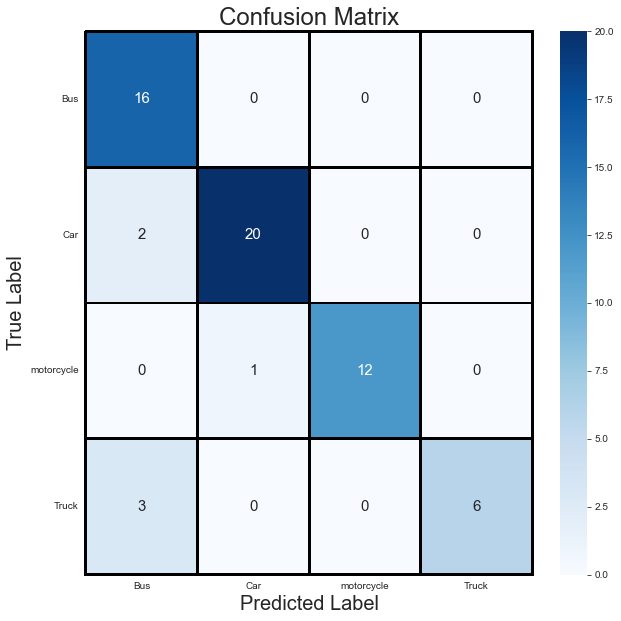

In [60]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=15):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Blues',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=2, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)

    # Plot confusion matrix
    plt.show()

    return

plot_confusion_matrix(labels, predictions, classes=classes)

In [61]:
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score,classification_report
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86        16
           1       0.95      0.91      0.93        22
           2       1.00      0.92      0.96        13
           3       1.00      0.67      0.80         9

    accuracy                           0.90        60
   macro avg       0.93      0.87      0.89        60
weighted avg       0.92      0.90      0.90        60



accuracy, precision, recall, f1_score

In [62]:
model_accuracy = round(accuracy_score(labels, predictions), 5)
print(f'accuracy_score:\t\t{model_accuracy}\n')

accuracy_score:		0.9



In [63]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
model_accuracy = round(accuracy_score(labels, predictions), 5)
model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
print('=============================================')
print(f'accuracy_score:\t\t{model_accuracy}\n')
print('_____________________________________________')
print(f'precision_score:\t{model_precision}\n')
print('_____________________________________________')
print(f'recall_score:\t\t{model_recall}\n')
print('_____________________________________________')
print(f'f1_score:\t\t{model_f1}\n')
print('_____________________________________________')

accuracy_score:		0.9

_____________________________________________
precision_score:	0.919047619047619

_____________________________________________
recall_score:		0.9

_____________________________________________
f1_score:		0.8997159019484601

_____________________________________________


In [64]:
def sen(Y_test,Y_pred,n):#n为分类数

    sen = []
    con_mat = confusion_matrix(Y_test,Y_pred)
    for i in range(n):
        tp = con_mat[i][i]
        fn = np.sum(con_mat[i,:]) - tp
        sen1 = tp / (tp + fn)
        sen.append(sen1)

    return sen

def spe(Y_test,Y_pred,n):

    spe = []
    con_mat = confusion_matrix(Y_test,Y_pred)
    for i in range(n):
        number = np.sum(con_mat[:,:])
        tp = con_mat[i][i]
        fn = np.sum(con_mat[i,:]) - tp
        fp = np.sum(con_mat[:,i]) - tp
        tn = number - tp - fn - fp
        spe1 = tn / (tn + fp)
        spe.append(spe1)

    return spe

sensitive = sen(labels, predictions, 4)
specific = spe(labels, predictions, 4)
print(f'sensitive:\t{sensitive}\n')
print(f'average sensitive:\t{np.mean(sensitive)}\n')
print('_____________________________________________')
print(f'specific:\t{specific}\n')
print(f'average specific:\t{np.mean(specific)}\n')
print('_____________________________________________')

sensitive:	[1.0, 0.9090909090909091, 0.9230769230769231, 0.6666666666666666]

average sensitive:	0.8747086247086248

_____________________________________________
specific:	[0.8863636363636364, 0.9736842105263158, 1.0, 1.0]

average specific:	0.965011961722488

_____________________________________________


ROC-AUC

D:\MySoftwares\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


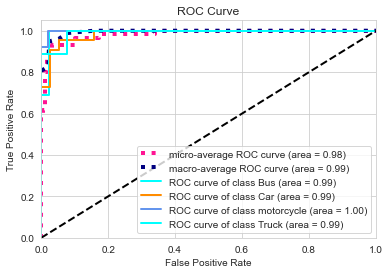

In [65]:
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_set[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_set.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

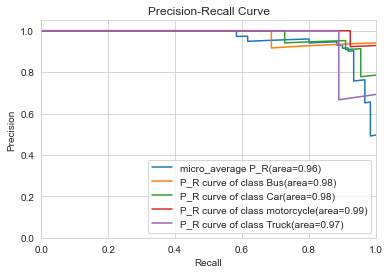

In [66]:
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i],recall[i],_ = precision_recall_curve(y_test_set[:,i],probs[:,i])
    average_precision[i] = average_precision_score(y_test_set[:,i],probs[:,i])

precision["micro"],recall["micro"],_ = precision_recall_curve(y_test_set.ravel(),probs.ravel())
average_precision["micro"] = average_precision_score(y_test_set,probs,average="micro")

plt.clf()
plt.plot(recall["micro"],precision["micro"],label = "micro_average P_R(area={0:0.2f})".format(average_precision["micro"]))
for i in range(n_classes):
    plt.plot(recall[i],precision[i],label = "P_R curve of class {0}(area={1:0.2f})".format(classes[i],average_precision[i]))

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc = "lower right")
plt.show()


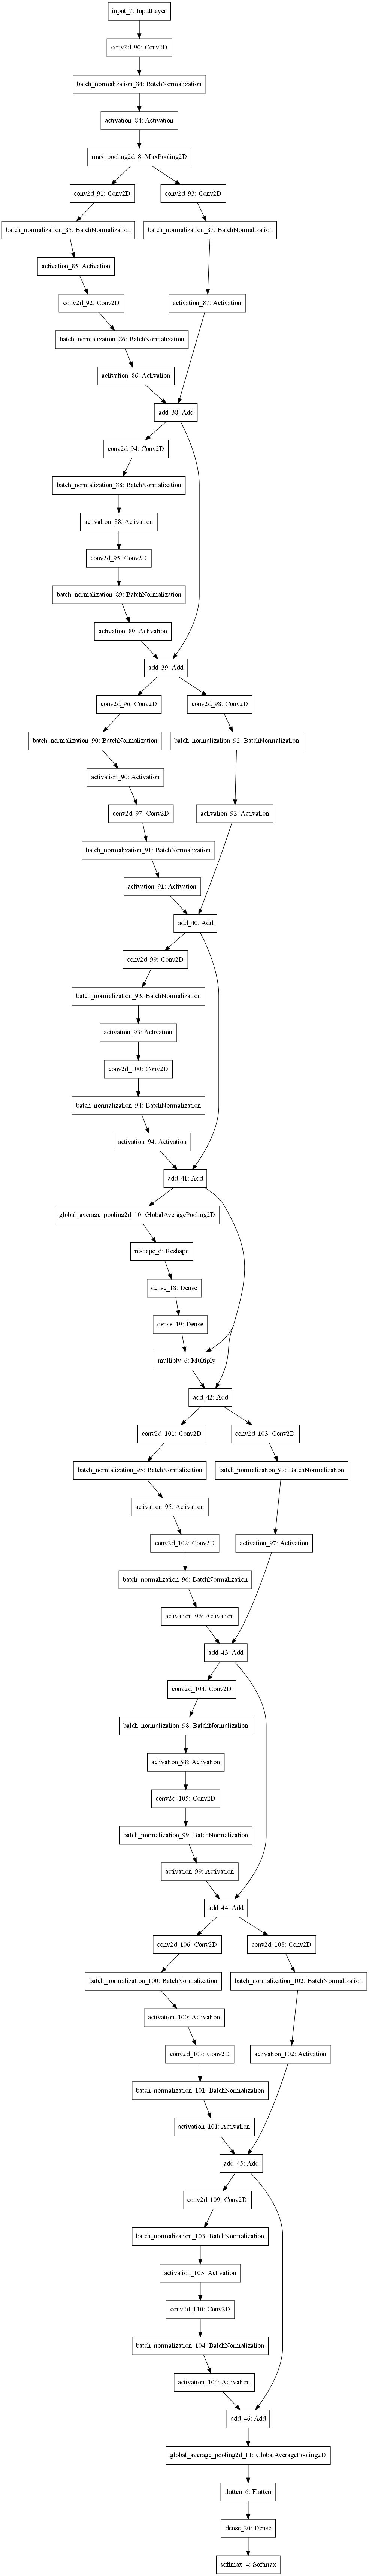

In [67]:
from tensorflow.keras.utils import plot_model
plot_model(model_b, to_file='se-resnet18.png')

In [ ]:
# 单模型测试
test_model = tf.keras.models.load_model('simpleNet.best65.h5', custom_objects={"mycrossentropy": mycrossentropy})
# print(test_model.summary())
# Final evaluation of the model

x,y = test_set.next()
scores = test_model.predict(x)
print(scores)
print(len(scores))
predictions = np.argmax(scores, axis=-1)
labels = np.argmax(y, axis=-1)
_val_f1 = f1_score(labels, predictions, average='macro')
_val_recall = recall_score(labels, predictions, average='macro')
_val_precision = precision_score(labels, predictions, average='macro')

print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))